In [99]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Input, SimpleRNN, Dropout, Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score, recall_score, confusion_matrix
from sklearn.model_selection import KFold


In [100]:
# Load the dataset
data = pd.read_csv('https://archive.ics.uci.edu/static/public/911/data.csv')

In [101]:
data.head()

,num_records,recipe_number,recipe_code,recipe_name,comment_id,user_id,user_name,user_reputation,created_at,reply_count,thumbs_up,thumbs_down,stars,best_score,text
0,0,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2G3aneMRgRMZwXqIHmSdXSG1hEM,u_9iFLIhMa8QaG,Jeri326,1,1665619889,0,0,0,5,527,"I tweaked it a little, removed onions because ..."
1,1,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2FsPC83HtzCsQAtOxlbL6RcaPbY,u_Lu6p25tmE77j,Mark467,50,1665277687,0,7,0,5,724,Bush used to have a white chili bean and it ma...
2,2,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2FPrSGyTv7PQkZq37j92r9mYGkP,u_s0LwgpZ8Jsqq,Barbara566,10,1664404557,0,3,0,5,710,I have a very complicated white chicken chili ...
3,3,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2DzdSIgV9qNiuBaLoZ7JQaartoC,u_fqrybAdYjgjG,jeansch123,1,1661787808,2,2,0,0,581,"In your introduction, you mentioned cream chee..."
4,4,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2DtZJuRQYeTFwXBoZRfRhBPEXjI,u_XXWKwVhKZD69,camper77,10,1664913823,1,7,0,0,820,Wonderful! I made this for a &#34;Chili/Stew&#...


In [102]:
# Preprocessing steps for the 'review_text' column
data['review_text'] = data['text'].str.lower()
data['review_text'] = data['review_text'].str.replace(r'[^\w\s]', '', regex=True)
data['review_text'] = data['review_text'].str.replace(r'\d+', '', regex=True)
data = data.dropna(subset=['review_text', 'best_score'])

In [103]:
data = data[data['stars'] >= 1]

In [104]:
from gensim.models import Word2Vec

# Word2Vec Embedding
sentences = data['review_text'].apply(lambda x: x.split()).tolist()
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# Correct the vocab_size to include an additional padding index
vocab_size = len(word2vec_model.wv) + 1  # Add 1 for padding index

# Initialize the embedding matrix
embedding_matrix = np.zeros((vocab_size, 100))

# Map words to indices and populate the embedding matrix
word_index = {word: idx + 1 for idx, word in enumerate(word2vec_model.wv.index_to_key)}  # Start indexing from 1
for word, idx in word_index.items():
    embedding_matrix[idx] = word2vec_model.wv[word]

In [105]:
# Aggregate data by recipe -- EXAMPLE (adjust as needed)
agg_data = data.groupby('recipe_code').agg({
    'stars': 'mean',  # Average rating
    'comment_id': 'count',  # Count of comments as a proxy for engagement
    'best_score': 'mean',  # Average best score
    'thumbs_up': 'sum',  # Sum of thumbs up
    'thumbs_down': 'sum',  # Sum of thumbs down
}).reset_index()

# Rename columns to reflect their new meaning
agg_data.rename(columns={
    'stars': 'avg_stars', 
    'comment_id': 'comment_count', 
    'best_score': 'avg_best_score',
    'thumbs_up': 'total_thumbs_up',
    'thumbs_down': 'total_thumbs_down'
}, inplace=True)

# Create a new 'popularity' score, possibly weighted
agg_data['popularity'] = agg_data['avg_stars'] * 0.4 + agg_data['comment_count'] * 0.2 + agg_data['avg_best_score'] * 0.2 + agg_data['total_thumbs_up'] * 0.1 + agg_data['total_thumbs_down'] * 0.1
# Merge the aggregated data with the original data on 'recipe_code'
data = data.merge(agg_data[['recipe_code', 'popularity']], on='recipe_code', how='left')

In [108]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, Dropout, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Extract features and target
X_text = data['review_text']
X_numeric = data['popularity']
y = data['stars'].values - 1  # Adjust stars to be 0-4 for classification

# Tokenize and pad the review_text column
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_text)
X_text_seq = tokenizer.texts_to_sequences(X_text)
X_text_pad = pad_sequences(X_text_seq, maxlen=200)

# Reshape numeric features to have the same number of dimensions as padded sequences
X_numeric_reshaped = X_numeric.values.reshape(-1, 1)

# Combine numeric features with padded sequences
X_combined = np.hstack((X_numeric_reshaped, X_text_pad))

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Ensure the text input is correctly padded to the expected length
X_train_text = X_train[:, 1:]
X_test_text = X_test[:, 1:]

# Build the model
input_numeric = Input(shape=(1,))
input_text = Input(shape=(200,))
embedding_layer = Embedding(input_dim=vocab_size, output_dim=100, input_length=200, weights=[embedding_matrix], trainable=False)(input_text)
flatten_layer = Flatten()(embedding_layer)
concat_layer = Concatenate()([input_numeric, flatten_layer])
dense_layer = Dense(128, activation='relu')(concat_layer)
dropout_layer = Dropout(0.2)(dense_layer)
output_layer = Dense(5, activation='softmax')(dropout_layer)

model = Model(inputs=[input_numeric, input_text], outputs=output_layer)
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit([X_train[:, :1], X_train_text], y_train, validation_split=0.2, epochs=10, batch_size=32)

Epoch 1/10


/Users/huiyisang/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8091 - loss: 0.7468 - val_accuracy: 0.8491 - val_loss: 0.5378
Epoch 2/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8435 - loss: 0.4660 - val_accuracy: 0.8446 - val_loss: 0.5626
Epoch 3/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8751 - loss: 0.3712 - val_accuracy: 0.8412 - val_loss: 0.5905
Epoch 4/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9023 - loss: 0.2875 - val_accuracy: 0.8294 - val_loss: 0.6803
Epoch 5/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9253 - loss: 0.2126 - val_accuracy: 0.8256 - val_loss: 0.7483
Epoch 6/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9476 - loss: 0.1538 - val_accuracy: 0.8226 - val_loss: 0.8657
Epoch 7/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9589 - loss: 0.1240 - val_accuracy: 0.8173 - val_loss: 0.9229
Epoch 8/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9654 - loss: 0.1075 - val_accuracy: 0.8154 - val_

In [113]:

# Evaluation Function
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    y_pred = np.argmax(predictions, axis=1)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average = 'macro')
    recall = recall_score(y_test, y_pred, average = 'macro')
    report = classification_report(y_test, y_pred, target_names=['class_0', 'class_1', 'class_2', 'class_3', 'class_4'])
    print(f"Accuracy: {accuracy}")
    print(f"F1 Score: {f1}")
    print(f"Recall: {recall}")
    print(f"Classification Report:\n{report}")


evaluate_model(model, [X_test[:, :1], X_test[:,1:]], y_test)

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Accuracy: 0.8192296026690931
F1 Score: 0.2690966301022767
Recall: 0.25163374610262335
Classification Report:
              precision    recall  f1-score   support

     class_0       0.10      0.02      0.03        63
     class_1       0.18      0.05      0.08        41
     class_2       0.33      0.11      0.17        98
     class_3       0.26      0.12      0.17       328
     class_4       0.86      0.96      0.90      2767

    accuracy                           0.82      3297
   macro avg       0.35      0.25      0.27      3297
weighted avg       0.76      0.82      0.78      3297



104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


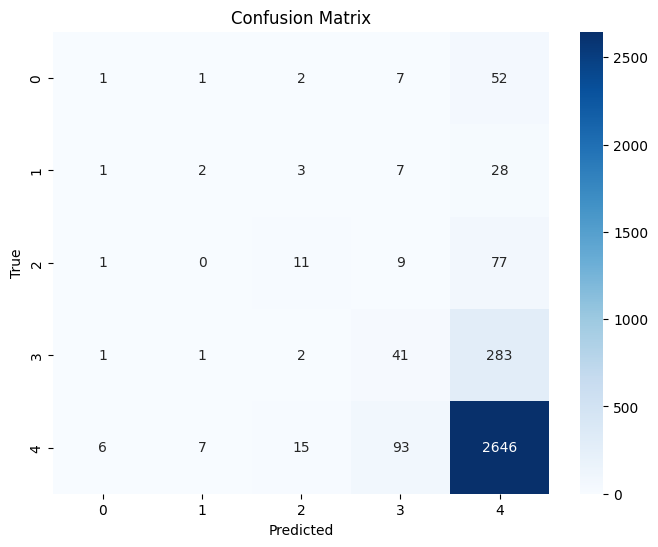

In [115]:
# Ensure both inputs are provided during prediction
y_pred = model.predict([X_test[:, :1], X_test[:, 1:]])
# Convert predictions to class indices
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

import matplotlib.pyplot as plt
import seaborn as sns
# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()